In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings
import optuna
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import TimeSeriesSplit

c:\Users\p0f3h\anaconda3\envs\2024project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Define the ticker symbol for the Shanghai Composite Index
ticker = '000001.SS'

# Define the date range
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download the full dataset sourced from yahoo finance
data = yf.download(ticker, start=start_date, end=end_date)

# Print some samples
print(pd.concat([data.head(1), data.tail(1)]))


[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-01-02  2112.125977  2113.110107  2101.016113  2109.386963  2109.386963   
2023-12-29  2950.836914  2975.031982  2950.017090  2974.935059  2974.935059   

            Volume  
Date                
2014-01-02   68500  
2023-12-29  290700  


Train: 1944, Test: 487


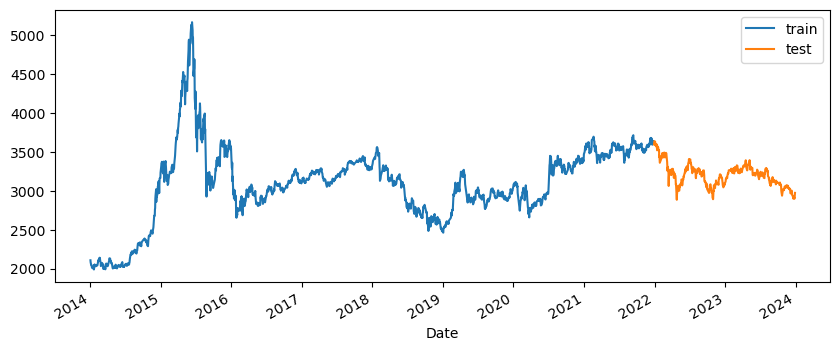

In [6]:
# Define a function for train-test split
def train_test_split(X, size=0.8):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

# Split train set and test set
train, test = train_test_split(X=data['Close'], size=0.8)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets 
fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend()
plt.show()

In [7]:
# Train an ARIMA model using the auto_arima function on the training data
arima_model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)

# Print a summary of the fitted ARIMA model
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20347.239, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20410.570, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20403.195, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20401.873, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20409.129, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20400.015, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20399.015, Time=0.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=20326.165, Time=3.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=20394.165, Time=1.83 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=20328.057, Time=2.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=20355.667, Time=4.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20327.297, Time=3.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=20382.739, Time=1.52 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=20329.444, Time=4.00 sec
 ARIMA(3,1,2)(0,0,0

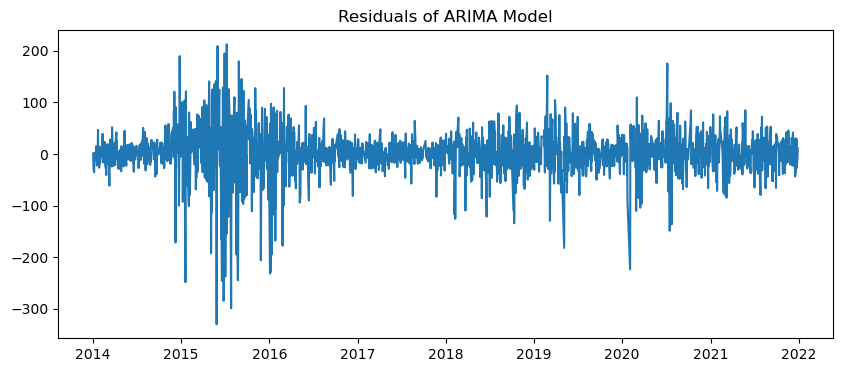

In [8]:
# Extract residuals
arima_residuals = arima_model.resid()
# Replace the first value of the residuals 
arima_residuals.iloc[0] = np.mean(arima_residuals[1:])
# Plot the residuals
plt.figure(figsize=(10,4))
plt.plot(arima_residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

In [9]:
# Define GARCH model function
def garch_model(data, p=1, o=0, q=1, mean='constant', vol='GARCH', dist='normal'):
    model = arch_model(
        data, 
        p=p, o=o, q=q, 
        mean=mean, 
        vol=vol, 
        dist=dist
    )
    return model

# Apply GARCH model to ARIMA residuals
GARCH = garch_model(arima_residuals)
# Fit the GARCH model
garch_results = GARCH.fit(disp='off', show_warning=False)

# Display GARCH model fitting summary
print(garch_results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9627.89
Distribution:                  Normal   AIC:                           19263.8
Method:            Maximum Likelihood   BIC:                           19286.1
                                        No. Observations:                 1944
Date:                Sun, Aug 25 2024   Df Residuals:                     1943
Time:                        14:21:27   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.7807      0.622      1.256      0.209 [ -0.438,  1.99

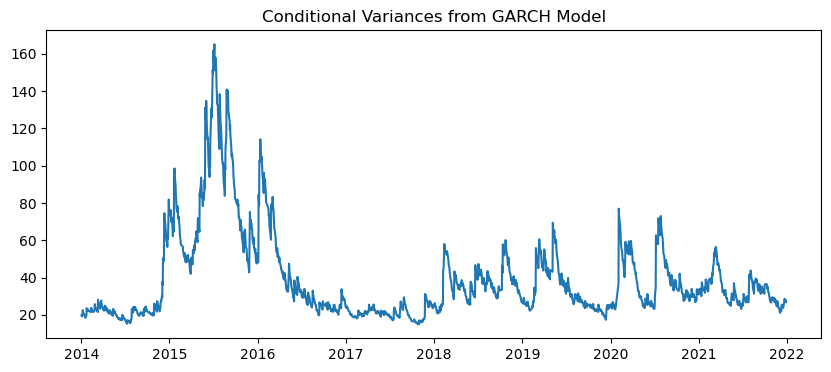

In [10]:
# Extract the conditional variances from the GARCH model
conditional_variances = garch_results.conditional_volatility

# Plot the conditional variances
plt.figure(figsize=(10,4))
plt.plot(conditional_variances)
plt.title('Conditional Variances from GARCH Model')
plt.show()

In [11]:
# Combine arima_residuals and conditional_variances into a single dataset
combined_data = np.column_stack((arima_residuals, conditional_variances))

# Normalize the data
sc = MinMaxScaler(feature_range=(0, 1))
sc_data = sc.fit_transform(combined_data)

In [12]:
# Define function to prepare the data
def prepare_data(seq_len, data):
    X = np.array([data[i:i+seq_len, :] for i in range(data.shape[0] - seq_len)])
    y = np.array([data[i+seq_len, 0] for i in range(data.shape[0] - seq_len)])  # Predicting ARIMA residuals
    return X, y

In [13]:
# Create an SQLite database to store the study
study_name = 'test_ARIMA_GARCH_LSTM'
storage_name = f'sqlite:///{study_name}.db'

# Create an Optuna study with the SQLite storage
study = optuna.create_study(direction='minimize', storage=storage_name, study_name=study_name, load_if_exists=True)

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized (excluding batch size and epochs)
    seq_len = trial.suggest_int('seq_len', 2, 10)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    units_list = [trial.suggest_int(f'units_l{i}', 32, 128) for i in range(num_layers)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['linear', 'relu', 'sigmoid'])
    
    # Fixed batch size and epochs
    batch_size = 32
    epochs = 100
    
    # Prepare the data using the suggested sequence length
    X_train, y_train = prepare_data(seq_len, sc_data)

    # Create the LSTM model with the suggested hyperparameters
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=units_list[0], input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=(num_layers > 1), kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers
    for i in range(1, num_layers):
        model.add(LSTM(units=units_list[i], return_sequences=(i < num_layers - 1), kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation=activation))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=20)
    val_loss_list = []

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train the model
        history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=0,
                            callbacks=[early_stopping])
        
        # Get the validation loss
        val_loss = min(history.history['val_loss'])
        val_loss_list.append(val_loss)
    
    # Return the average validation loss across folds
    return np.mean(val_loss_list)

# Optimize the study
study.optimize(objective, n_trials=50)

[I 2024-08-25 14:21:30,653] A new study created in RDB with name: test_ARIMA_GARCH_LSTM
[I 2024-08-25 14:27:21,444] Trial 0 finished with value: 0.007224493735702708 and parameters: {'seq_len': 7, 'num_layers': 3, 'units_l0': 108, 'units_l1': 98, 'units_l2': 111, 'dropout_rate': 0.3704805396447679, 'l2_reg': 7.072506254181148e-05, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.007224493735702708.
[I 2024-08-25 14:31:29,749] Trial 1 finished with value: 0.007377691307920031 and parameters: {'seq_len': 6, 'num_layers': 2, 'units_l0': 69, 'units_l1': 57, 'dropout_rate': 0.39594951646800236, 'l2_reg': 0.009945668152729556, 'activation': 'linear'}. Best is trial 0 with value: 0.007224493735702708.
[I 2024-08-25 14:34:09,696] Trial 2 finished with value: 0.007189749969984405 and parameters: {'seq_len': 9, 'num_layers': 1, 'units_l0': 112, 'dropout_rate': 0.2794990639206154, 'l2_reg': 0.0009024856146121459, 'activation': 'sigmoid'}. Best is trial 2 with value: 0.007189749969984405.
[

In [17]:
# Load the Optuna study from the SQLite database
study_name='test_ARIMA_GARCH_LSTM'
storage_name = f'sqlite:///{study_name}.db'
study = optuna.load_study(study_name=study_name, storage=storage_name)

# Extract the best trial's hyperparameters
best_trial = study.best_trial
seq_len = best_trial.params['seq_len']
layers = best_trial.params['num_layers']
dropout_rate = best_trial.params['dropout_rate']
l2_reg = best_trial.params['l2_reg']
activation = best_trial.params['activation']

# Extract units for each layer based on the number of layers
units = [best_trial.params[f'units_l{i}'] for i in range(layers)]

# Fixed parameters
epochs = 100
batch_size = 32

# Prepare data for LSTM model using the best sequence length
X_train, y_train = prepare_data(seq_len, sc_data)

print(X_train.shape, y_train.shape)

# Define the LSTM model with optimal hyperparameters
model = Sequential()

# First LSTM layer with return_sequences=True if layers > 1
model.add(LSTM(units=units[0], input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences=(layers > 1), kernel_regularizer=l2(l2_reg)))
model.add(Dropout(dropout_rate))  # Dropout layer

# If there are multiple layers, add more LSTM and Dropout layers
for i in range(1, layers):
    model.add(LSTM(units=units[i], return_sequences=(i < layers - 1), kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))  # Dropout layer

# Output layer with the specified activation function
model.add(Dense(1, activation=activation))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Model summary
model.summary()

(1935, 9, 2) (1935,)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_111 (LSTM)             (None, 9, 110)            49720     
                                                                 
 dropout_111 (Dropout)       (None, 9, 110)            0         
                                                                 
 lstm_112 (LSTM)             (None, 9, 94)             77080     
                                                                 
 dropout_112 (Dropout)       (None, 9, 94)             0         
                                                                 
 lstm_113 (LSTM)             (None, 68)                44336     
                                                                 
 dropout_113 (Dropout)       (None, 68)                0         
                                                                 
 dense_51 (Dense)            (No

In [18]:
# Print the best trial's value (objective value)
print(f"Best trial value (loss): {best_trial.value}")

# Print the hyperparameters of the best trial
print("Best trial hyperparameters:")
for param_name, param_value in best_trial.params.items():
    print(f"  {param_name}: {param_value}")

Best trial value (loss): 0.007165674970019608
Best trial hyperparameters:
  seq_len: 9
  num_layers: 3
  units_l0: 110
  units_l1: 94
  units_l2: 68
  dropout_rate: 0.19906374582977887
  l2_reg: 0.005692611023767616
  activation: sigmoid


In [19]:
# Suppress specific warning messages
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

Epoch 1/50
49/49 - 29s - loss: 1.0100 - val_loss: 0.4344 - 29s/epoch - 601ms/step
Epoch 2/50
49/49 - 4s - loss: 0.2247 - val_loss: 0.0836 - 4s/epoch - 77ms/step
Epoch 3/50
49/49 - 4s - loss: 0.0445 - val_loss: 0.0156 - 4s/epoch - 78ms/step
Epoch 4/50
49/49 - 4s - loss: 0.0126 - val_loss: 0.0057 - 4s/epoch - 84ms/step
Epoch 5/50
49/49 - 4s - loss: 0.0083 - val_loss: 0.0042 - 4s/epoch - 78ms/step
Epoch 6/50
49/49 - 4s - loss: 0.0078 - val_loss: 0.0041 - 4s/epoch - 88ms/step
Epoch 7/50
49/49 - 4s - loss: 0.0077 - val_loss: 0.0042 - 4s/epoch - 89ms/step
Epoch 8/50
49/49 - 5s - loss: 0.0078 - val_loss: 0.0041 - 5s/epoch - 99ms/step
Epoch 9/50
49/49 - 4s - loss: 0.0077 - val_loss: 0.0041 - 4s/epoch - 85ms/step
Epoch 10/50
49/49 - 4s - loss: 0.0077 - val_loss: 0.0041 - 4s/epoch - 86ms/step
Epoch 11/50
49/49 - 4s - loss: 0.0077 - val_loss: 0.0041 - 4s/epoch - 90ms/step
1/1 [==============================] - 0s 142ms/step
Epoch 1/50
49/49 - 5s - loss: 0.0078 - val_loss: 0.0041 - 5s/epoch - 97ms

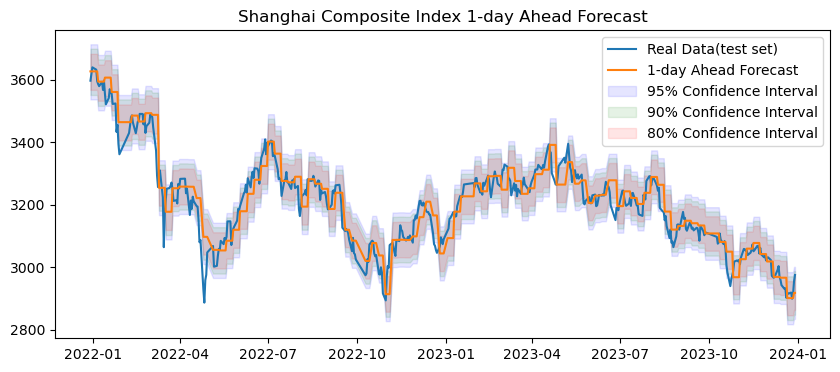

Epoch 1/50
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 82ms/step
Epoch 2/50
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 73ms/step
Epoch 3/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 67ms/step
Epoch 4/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 66ms/step
Epoch 5/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 64ms/step
Epoch 6/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 58ms/step
Epoch 7/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 65ms/step
Epoch 8/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 55ms/step
Epoch 9/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 51ms/step
Epoch 10/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 53ms/step
Epoch 11/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 54ms/step
Epoch 12/50
49/49 - 3s - loss: 0.0076 - val_loss: 0.0041 - 3s/epoch - 57ms/step
Epoch 13/50
49/49 - 2s - loss: 0.0076 - val_loss:

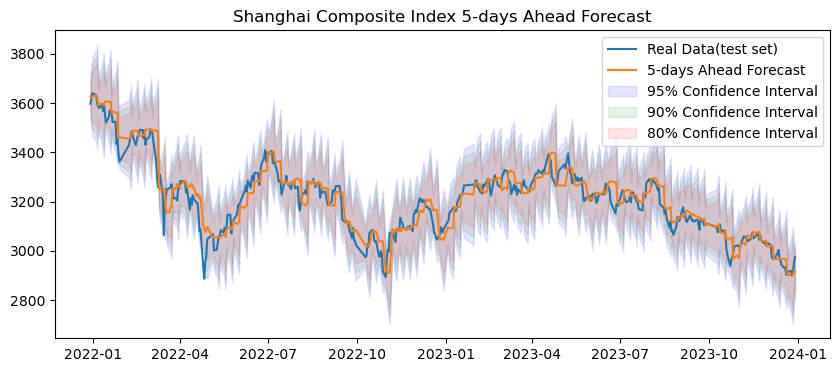

Epoch 1/50
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 91ms/step
Epoch 2/50
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 91ms/step
Epoch 3/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 96ms/step
Epoch 4/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 107ms/step
Epoch 5/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 105ms/step
Epoch 6/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 97ms/step
Epoch 7/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 103ms/step
1/1 [==============================] - 0s 61ms/step
Epoch 1/50
50/50 - 5s - loss: 0.0077 - val_loss: 0.0038 - 5s/epoch - 91ms/step
Epoch 2/50
50/50 - 5s - loss: 0.0077 - val_loss: 0.0038 - 5s/epoch - 96ms/step
Epoch 3/50
50/50 - 5s - loss: 0.0077 - val_loss: 0.0038 - 5s/epoch - 93ms/step
Epoch 4/50
50/50 - 5s - loss: 0.0077 - val_loss: 0.0038 - 5s/epoch - 96ms/step
Epoch 5/50
50/50 - 5s - loss: 0.0076 - val_loss: 0.0038 - 5s/epoch - 101ms/s

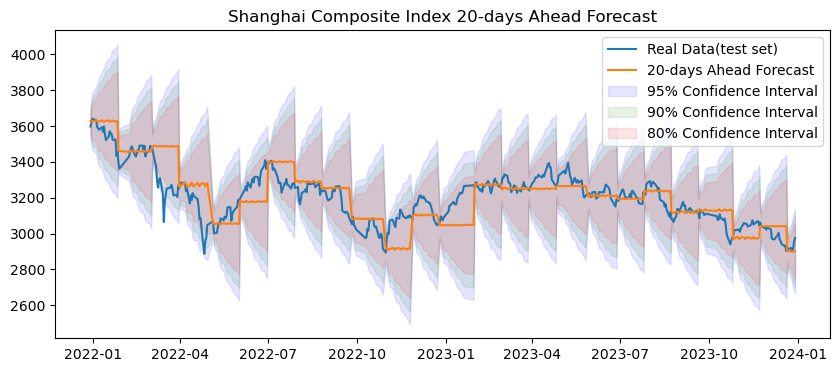

Epoch 1/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 110ms/step
Epoch 2/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 105ms/step
Epoch 3/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 107ms/step
Epoch 4/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 104ms/step
Epoch 5/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 104ms/step
Epoch 6/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 105ms/step
Epoch 7/50
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 104ms/step
1/1 [==============================] - 0s 63ms/step
Epoch 1/50
52/52 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 115ms/step
Epoch 2/50
52/52 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 107ms/step
Epoch 3/50
52/52 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 118ms/step
Epoch 4/50
52/52 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 108ms/step
Epoch 5/50
52/52 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch -

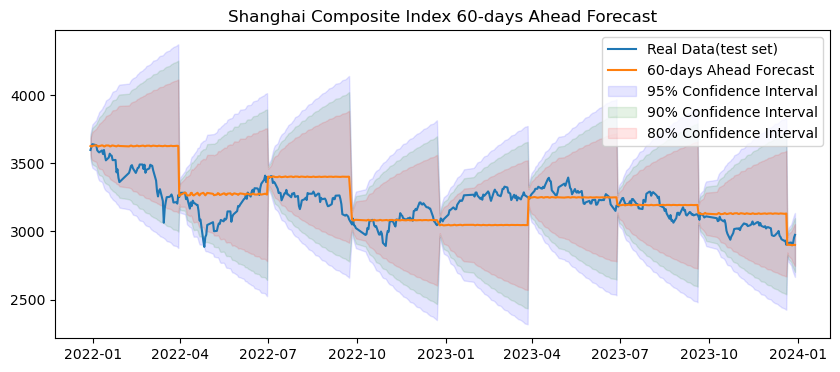

1-day Ahead Forecast:
MAE: 36.747140199215686
RMSE: 49.82990278408303
MAPE: 1.153676814557276%

5-days Ahead Forecast:
MAE: 36.72403816913562
RMSE: 49.66026664526726
MAPE: 1.1524650009023694%

20-days Ahead Forecast:
MAE: 69.22872092210707
RMSE: 96.73908294197156
MAPE: 2.1782898961301354%

60-days Ahead Forecast:
MAE: 113.47988389351778
RMSE: 146.68078104098046
MAPE: 3.5481646098047923%



In [20]:
# Function to perform forecast with specific confidence level
def multi_step_forecast(n_periods=1, alpha=0.05):
    arima_forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True, alpha=alpha)
    
    lstm_forecasts = []
    
    # Prepare the input for LSTM model from the last residuals and conditional variances
    last_residuals = arima_residuals[-seq_len:]
    last_conditional_variances = conditional_variances[-seq_len:]
    combined_last_data = np.column_stack((last_residuals, last_conditional_variances)).reshape(1, seq_len, 2)
    
    # Iterate to generate multi-step forecasts
    for _ in range(n_periods):
        combined_last_data_scaled = sc.transform(combined_last_data.reshape(-1, 2)).reshape(1, seq_len, 2)
        lstm_forecast_scaled = model.predict(combined_last_data_scaled)[0, 0]
        lstm_forecast = sc.inverse_transform([[lstm_forecast_scaled, 0]])[0, 0]
        lstm_forecasts.append(lstm_forecast)
        
        # Update the last data with the new LSTM forecast
        combined_last_data = np.append(
            combined_last_data[0, 1:], 
            [[lstm_forecast, last_conditional_variances.iloc[-1]]], 
            axis=0
        ).reshape(1, seq_len, 2)
    
    return (
        arima_forecast.tolist()[:n_periods],
        np.asarray(conf_int).tolist()[:n_periods],
        lstm_forecasts
    )
    
# Function to retrain the LSTM model
def retrain_lstm(arima_residuals, conditional_variances):
    combined_data = np.column_stack((arima_residuals, conditional_variances))
    sc_data = sc.fit_transform(combined_data)
    X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
    y_train = np.array([sc_data[i + seq_len, 0] for i in range(sc_data.shape[0] - seq_len)])
    
    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model with early stopping
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])


# Define the function for re-estimating ARIMA and GARCH models
def reestimate_models(current_train):
    # Re-estimate the ARIMA model with the current training data
    arima_model = auto_arima(current_train, trace=False, error_action='ignore', suppress_warnings=True)
    arima_residuals = arima_model.resid()
    arima_residuals.iloc[0] = np.mean(arima_residuals[1:])
    
    # Re-fit the GARCH model on the new ARIMA residuals
    garch_results = arch_model(arima_residuals, vol='Garch', p=1, q=1).fit(disp="off")
    
    return arima_model, garch_results

# Perform forecasts and evaluations for different periods
forecast_periods = {'1-day': 1, '5-days': 5, '20-days': 20, '60-days': 60}
results = {}

for period_name, n_periods in forecast_periods.items():
    # Creat empty lists for storing results
    arima_predictions = []
    confidence_intervals_95 = []
    confidence_intervals_90 = []
    confidence_intervals_80 = []
    lstm_predictions = []
    # Define the ARIMA model GARCH model, and LSTM model for each time horizon
    current_train = train.copy()
    arima_model, garch_results = reestimate_models(current_train)
    arima_residuals = arima_model.resid()
    arima_residuals.iloc[0] = np.mean(arima_residuals[1:])
    conditional_variances = garch_results.conditional_volatility
    retrain_lstm(arima_residuals, conditional_variances)
    # For daily forecast, we choose to re-estimate parameters every 5 forecasts
    reestimate_interval = 5 if period_name == '1-day' else 1
    forecasts_since_last_reestimate = 0
    
    for i in range(0, len(test), n_periods):
        # Perform forecast
        arima_forecast_95, conf_95, lstm_forecasts = multi_step_forecast(n_periods=n_periods, alpha=0.05)
        arima_forecast_90, conf_90, _ = multi_step_forecast(n_periods=n_periods, alpha=0.10)
        arima_forecast_80, conf_80, _ = multi_step_forecast(n_periods=n_periods, alpha=0.20)

        for j in range(n_periods):
            if i + j < len(test):
                # Store results
                arima_predictions.append(arima_forecast_95[j])
                confidence_intervals_95.append(conf_95[j])
                confidence_intervals_90.append(conf_90[j])
                confidence_intervals_80.append(conf_80[j])
                lstm_predictions.append(lstm_forecasts[j])
                
        # Update the training sets with new observed data
        current_train = pd.concat([current_train, test[i:i+n_periods]])
        
        # Re-estimate the ARIMA and GARCH models with the updated training sets
        forecasts_since_last_reestimate += 1
        if forecasts_since_last_reestimate >= reestimate_interval:
            arima_model, garch_results = reestimate_models(current_train)
            arima_residuals = arima_model.resid()
            arima_residuals.iloc[0] = np.mean(arima_residuals[1:])
            conditional_variances = garch_results.conditional_volatility
            forecasts_since_last_reestimate = 0
            
        
        # Retrain the LSTM model based on the forecast period
        if period_name == '1-day' and (i + n_periods) % 5 == 0:
            retrain_lstm(arima_residuals, conditional_variances)
        elif period_name == '5-days' and (i + n_periods) % (5 * 2) == 0:  
            retrain_lstm(arima_residuals, conditional_variances)
        elif period_name == '20-days' and (i + n_periods) % (20 * 2) == 0:  
            retrain_lstm(arima_residuals, conditional_variances)
        elif period_name == '60-days' and (i + n_periods) % (60 * 2) == 0:  
            retrain_lstm(arima_residuals, conditional_variances)

    # Combine ARIMA and LSTM Forecasts
    arima_forecast_series = pd.Series(arima_predictions[:len(test)], index=test.index[:len(arima_predictions)])
    conf_int_df_95 = pd.DataFrame(confidence_intervals_95[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    conf_int_df_90 = pd.DataFrame(confidence_intervals_90[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    conf_int_df_80 = pd.DataFrame(confidence_intervals_80[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    lstm_forecast_series = pd.Series(lstm_predictions[:len(test)], index=test.index[:len(lstm_predictions)])

    final_forecast = arima_forecast_series + lstm_forecast_series

    # Evaluate the Forecast
    mae = mean_absolute_error(test[:len(final_forecast)], final_forecast)
    rmse = np.sqrt(mean_squared_error(test[:len(final_forecast)], final_forecast))
    mape = np.mean(np.abs((test[:len(final_forecast)] - final_forecast) / test[:len(final_forecast)])) * 100

    # Store results
    results[period_name] = {
        'forecast': final_forecast,
        'confidence_intervals_95': conf_int_df_95,
        'confidence_intervals_90': conf_int_df_90,
        'confidence_intervals_80': conf_int_df_80,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    # Print the evaluation metrics
    print(f'{period_name.capitalize()} Ahead Forecast:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%\n')

    # Plot the results
    plt.figure(figsize=(10, 4))
    plt.plot(test, label='Real Data(test set)')
    plt.plot(final_forecast, label=f'{period_name.capitalize()} Ahead Forecast')

    # Plot different confidence intervals with different colors
    plt.fill_between(conf_int_df_95.index, conf_int_df_95['lower'], conf_int_df_95['upper'], color='b', alpha=0.1, label='95% Confidence Interval')
    plt.fill_between(conf_int_df_90.index, conf_int_df_90['lower'], conf_int_df_90['upper'], color='g', alpha=0.1, label='90% Confidence Interval')
    plt.fill_between(conf_int_df_80.index, conf_int_df_80['lower'], conf_int_df_80['upper'], color='r', alpha=0.1, label='80% Confidence Interval')

    plt.title(f'Shanghai Composite Index {period_name.capitalize()} Ahead Forecast')
    plt.legend()
    plt.show()

# Summarize results for each forecasting period
for period_name, result in results.items():
    print(f"{period_name.capitalize()} Ahead Forecast:")
    print(f"MAE: {result['mae']}")
    print(f"RMSE: {result['rmse']}")
    print(f"MAPE: {result['mape']}%\n")
